# plus total variance regularizer

# Loading NYU Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np

import timeit
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data

import os
import scipy
class DepthDataset(Dataset):
    def __init__(self, data_dir):
        sub_folders=os.listdir(data_dir+'/RGB')
        self.data_files=[]
        for folder in sub_folders:
            files=os.listdir(data_dir+'/RGB/'+folder)
            for file in files:
                self.data_files.append(folder+'/'+file)
        self.data_dir=data_dir
#         sort(self.data_files)      

    def __getitem__(self, index):
        name=self.data_files[index]
        img=torch.from_numpy(h5py.File(self.data_dir+'/RGB/'+name,'r')['rgbOut'].value).float()
        depth=torch.from_numpy(h5py.File(self.data_dir+'/DEP/'+name,'r')['depthOut'].value).float()
        return img,depth

    def __len__(self):
        print('len',len(self.data_files))
        return len(self.data_files)

In [6]:
dataset=DepthDataset('../Data_old')
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

In [7]:
N=dataset.__len__()
NUM_TRAIN = int(N*0.9)
NUM_VAL = N-NUM_TRAIN
print("NUM_TRAIN:",NUM_TRAIN,",NUM_VAL:",NUM_VAL)
batch_size=20
loader_train = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0),num_workers=8)
loader_val = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN),num_workers=8)

len 265
NUM_TRAIN: 238 ,NUM_VAL: 27


In [8]:
# define network

dtype = torch.FloatTensor
#dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU


class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # \"flatten\" the C * H * W values into a single vector per image
    

class Unflatten(nn.Module):
    def __init__(self,w,h):
        super(Unflatten,self).__init__()
        self.w=w
        self.h=h
    def forward(self, x):
        N, S = x.size() # read in N, C, H, W
        return x.view(N, self.w, self.h)  # \"flatten\" the C * H * W values into a single vector per image

class crop(nn.Module):
    def forward(self,x):
        N,C,H,W = x.size()
        return x[:,:,0:H-1,0:W-1].squeeze()
class printLayer(nn.Module):
    def forward(self,x):
        #print('layer size:',x.size())
        print('max element:', x.max())
        return x

In [9]:
dtype = torch.cuda.FloatTensor
#del coarse_model
coarse_model=nn.Sequential(
        nn.Conv2d(3,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,80,3,stride = 2,padding=0),
        #printLayer(),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,80,3,stride = 1,padding=1),
        #printLayer(),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,100,3,stride=2,padding=0),
        #printLayer(),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.Conv2d(100,120,3,stride=1,padding=1),
        #printLayer(),
        nn.BatchNorm2d(120),
        nn.ReLU(),
        #nn.ConvTranspose2d(360, 100, 3, stride = 4, padding=2,output_padding=1),
        #nn.BatchNorm2d(100),
        #nn.ReLU(),
        nn.Conv2d(120,1,1,stride=1,padding=0),
        crop()
    )
coarse_model.type(dtype)

Sequential (
  (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU ()
  (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU ()
  (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (8): ReLU ()
  (9): Conv2d(50, 80, kernel_size=(3, 3), stride=(2, 2))
  (10): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU ()
  (12): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (14): ReLU ()
  (15): Conv2d(80, 100, kernel_size=(3, 3), stride=(2, 2))
  (16): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (17): ReLU ()
  (18): Conv2d(100, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): BatchNorm2d(120, eps=1e-05, mome

In [17]:

print_every=400
lr=1e-3
reg=1e-4
adam_optim=optim.Adam(coarse_model.parameters(),lr=lr,weight_decay=reg)

#images_var=Variable(images_pytorch.type(dtype),requires_grad=False)
#depths_var=Variable(depths_pytorch.type(dtype),requires_grad=False)

def log_loss(pred,y):
    ep = 1e-6
    N,W,H = pred.size()
    pred = pred.contiguous().view(N,-1)
    y = y.view(N,-1)
    y = y+ep
    d = pred - y.log()
    d[y <= 0] = 0
    n = W*H
    loss = (d.pow(2).sum(1) / n - 0.5 / n/n * d.sum(1).pow(2)).sum()
    loss /= N
    #print('log loss=', loss)
    return loss

def tv_loss(img, tv_weight = 5e-5):
    N,H,W = img.size()
    img1 = img[:,1:H,1:W]
    img2 = img[:,1:H,0:W-1]
    img3 = img[:,0:H-1,1:W]
    loss = torch.sum((img1 - img2)**2+(img1 - img3)**2)*tv_weight
    #loss_var = Variable(loss)
    #print('tv_loss', loss)
    return loss

def loss_function(pred,y,tv_weight = 5e-6):
    loss = log_loss(pred,y) + tv_loss(pred, tv_weight)
    return loss


In [11]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

In [12]:
def evaluate(loader):
    ep = 1e-7

    thresh_1 = 0
    thresh_2 = 0
    abs_diff = 0
    rmse = 0

    for t,(x,y) in enumerate(loader):
        x_var=Variable(x.type(dtype),requires_grad=False)
        y_var=Variable(y.type(dtype),requires_grad=False)
        coarse_model.train(False)
        pred=coarse_model(x_var)

        #print(y_var.data.cpu().numpy())
        y_var=y_var.data.cpu().numpy() + ep
        pred=pred.data.cpu().numpy() + ep
        num_var = np.shape(y_var)[0]*np.shape(y_var)[1]*np.shape(y_var)[2]

        # threshold
        thresh_mat = np.zeros_like(y_var)
        thresh_mat[np.maximum(y_var / pred, pred / y_var) < 1.25] = 1
        thresh_1 += np.sum(thresh_mat)
        thresh_2 += num_var
        #print('t1 = %d, t2 = %d', thresh_1, thresh_2)

        # relative absolute diffe
        abs_diff += np.sum(np.absolute(y_var - pred) / y_var) / num_var

        rmse += np.sqrt(np.sum((y_var - pred) * (y_var - pred)) / num_var)


    abs_diff /= len(loader_train)

    print('percentage within threshold: ', thresh_1 / thresh_2)
    print('relative absolute diff = ', abs_diff)
    print('rmse = ', rmse)

In [16]:
coarse_model = torch.load('./save_model/model_2')

epoch: 0 average training loss: 7.57 validation loss: 5.67
percentage within threshold:  0.217854217854
relative absolute diff =  1220045.21813
rmse =  6.30395075783
epoch: 1 average training loss: 5.07 validation loss: 3.78


Process Process-132:
Process Process-129:
Process Process-133:
Process Process-131:
Process Process-135:
Process Process-136:
Process Process-134:
Process Process-130:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstr

KeyboardInterrupt: 

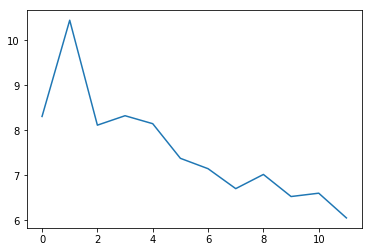

In [18]:

def train(model, loss_fn, optimizer, num_epochs = 1, plot_every = 10, eva_every = 4):
    losses = []
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_train_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=model(x_var)
            loss = loss_fn(pred, y_var)
            losses.append(loss.data.cpu().numpy())
            
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_train_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del x,y
        avg_train_loss/=num_batches
        num_batches=0
        avg_val_loss=0
        for t,(x,y) in enumerate(loader_val):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=coarse_model(x_var)
            loss=loss_fn(pred,y_var)
            avg_val_loss+=loss.data[0]
            num_batches+=1
            del x,y
        avg_val_loss/=num_batches
        print("epoch:",epoch,"average training loss: %.2f"%avg_train_loss,"validation loss: %.2f" %avg_val_loss)
        if(epoch % plot_every == 0):
            plt.plot(losses)
        if(epoch % eva_every == 0):
            evaluate(loader_val)
            

train(coarse_model,log_loss,adam_optim,num_epochs = 5)

In [14]:
torch.save(coarse_model, './save_model/model_2')

/home/cs231n/myVE35/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type crop. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
del coarse_model

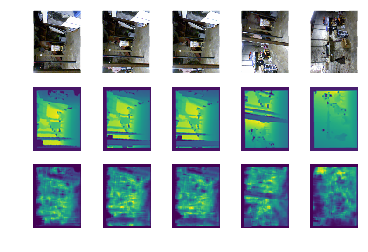

In [19]:
%matplotlib inline

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# visualize 5 images
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

In [21]:
# evaluate
ep = 1e-7

thresh_1 = 0
thresh_2 = 0
abs_diff = 0
rmse = 0

for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    
    #print(y_var.data.cpu().numpy())
    y_var=y_var.data.cpu().numpy() + ep
    pred=pred.data.cpu().numpy() + ep
    num_var = np.shape(y_var)[0]*np.shape(y_var)[1]*np.shape(y_var)[2]
    
    # threshold
    thresh_mat = np.zeros_like(y_var)
    thresh_mat[np.maximum(y_var / pred, pred / y_var) < 1.25] = 1
    thresh_1 += np.sum(thresh_mat)
    thresh_2 += num_var
    #print('t1 = %d, t2 = %d', thresh_1, thresh_2)
    
    # relative absolute diffe
    abs_diff += np.sum(np.absolute(y_var - pred) / y_var) / num_var
    
    rmse += np.sqrt(np.sum((y_var - pred) * (y_var - pred)) / num_var)
    
    
abs_diff /= len(loader_train)
    
print('percentage within threshold: ', thresh_1 / thresh_2)
print('relative absolute diff = ', abs_diff)
print('rmse = ', rmse)

percentage within threshold:  0.294765965354
relative absolute diff =  12717761.3703
rmse =  36.4677743923


epoch: 0 average training loss: 10.82 validation loss: 14.07
epoch: 1 average training loss: 10.83 validation loss: 14.78
epoch: 2 average training loss: 10.24 validation loss: 15.10
epoch: 3 average training loss: 11.04 validation loss: 14.46
epoch: 4 average training loss: 12.12 validation loss: 15.88
epoch: 5 average training loss: 11.55 validation loss: 14.76
epoch: 6 average training loss: 10.92 validation loss: 14.05
epoch: 7 average training loss: 10.50 validation loss: 13.78
epoch: 8 average training loss: 10.68 validation loss: 14.41
epoch: 9 average training loss: 11.07 validation loss: 14.26
epoch: 10 average training loss: 11.74 validation loss: 17.96
epoch: 11 average training loss: 13.09 validation loss: 14.92
epoch: 12 average training loss: 11.43 validation loss: 14.62
epoch: 13 average training loss: 10.22 validation loss: 13.89
epoch: 14 average training loss: 9.38 validation loss: 13.50
epoch: 15 average training loss: 8.91 validation loss: 13.87
epoch: 16 average tr

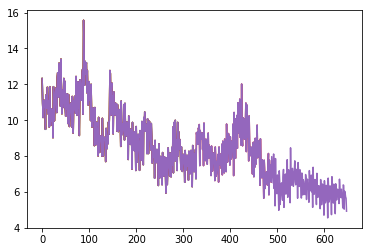

In [27]:
train(coarse_model,loss_log,adam_optim,num_epochs = 100, plot_every = 20)

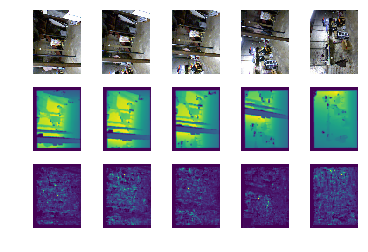

In [28]:
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

epoch: 0 average training loss: 1.67
epoch: 1 average training loss: 1.68
epoch: 2 average training loss: 1.82
epoch: 3 average training loss: 1.68
epoch: 4 average training loss: 1.68
epoch: 5 average training loss: 1.64
epoch: 6 average training loss: 1.70
epoch: 7 average training loss: 1.67
epoch: 8 average training loss: 1.63
epoch: 9 average training loss: 1.67
epoch: 10 average training loss: 1.57
epoch: 11 average training loss: 1.64
epoch: 12 average training loss: 1.66
epoch: 13 average training loss: 1.67
epoch: 14 average training loss: 1.65
epoch: 15 average training loss: 1.57
epoch: 16 average training loss: 1.68
epoch: 17 average training loss: 1.68
epoch: 18 average training loss: 1.67
epoch: 19 average training loss: 1.85
epoch: 20 average training loss: 1.69
epoch: 21 average training loss: 1.73
epoch: 22 average training loss: 1.65
epoch: 23 average training loss: 1.69
epoch: 24 average training loss: 1.66
epoch: 25 average training loss: 1.61
epoch: 26 average trai

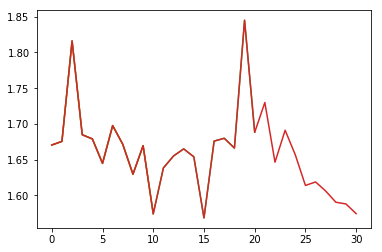

In [36]:

def train_overfit(model, loss_fn, optimizer, num_epochs = 1, plot_every = 10):
    losses = []
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_train_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            pred=model(x_var)
            loss = loss_fn(pred, y_var)
            losses.append(loss.data.cpu().numpy())
            
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_train_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            break
        avg_train_loss/=num_batches
        num_batches=0

        print("epoch:",epoch,"average training loss: %.2f"%avg_train_loss)
        if(epoch % plot_every == 0):
            plt.plot(losses)
            

train_overfit(coarse_model,loss_log,adam_optim,40)

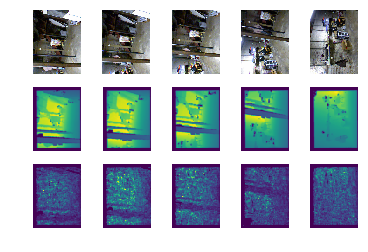

In [37]:
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

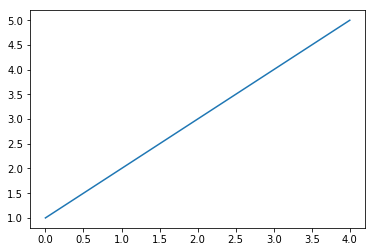

In [13]:
%matplotlib inline
a = [1,2,3,4]#np.array([1,2,3,4])
a.append(5)
plt.plot(a)

In [15]:
print(loader_train)

In [20]:
a = torch.zeros(3,3)
a[0,1] = 2
a[0,2] = 4
b = torch.sum(a,0)

print(a)
print(b)


 0  2  4
 0  0  0
 0  0  0
[torch.FloatTensor of size 3x3]


 0  2  4
[torch.FloatTensor of size 1x3]




 0  2  4
 0  0  0
 0  0  0
[torch.FloatTensor of size 3x3]


 6
 0
 0
[torch.FloatTensor of size 3x1]

